In [19]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
import torch
from torchvision import transforms

from BC import BC

In [20]:
# load samples
images_file = glob.glob("../Expert_samples_sem/*.png")
images_file = sorted(images_file, key= lambda name: int(name.split('/')[-1][:-4]))

veh_info = np.load("../Expert_samples_sem/veh_info_file_0.npy")
control_samples = np.load("../Expert_samples_sem/control_samples_0.npy")

In [21]:
# Dimensions
print(f"Vehicle information samples: {veh_info.shape}")
print(f"Control samples: {control_samples.shape}")
print(f"Images: {len(images_file)}")

Vehicle information samples: (370, 5)
Control samples: (369, 4)
Images: 3230


In [22]:
images = []
trans = transforms.Compose([transforms.ToTensor()])
for file in images_file[:369]:
    images.append(trans(Image.open(file).resize((80, 160))))

Text(0.5, 0.04, 'Frame')

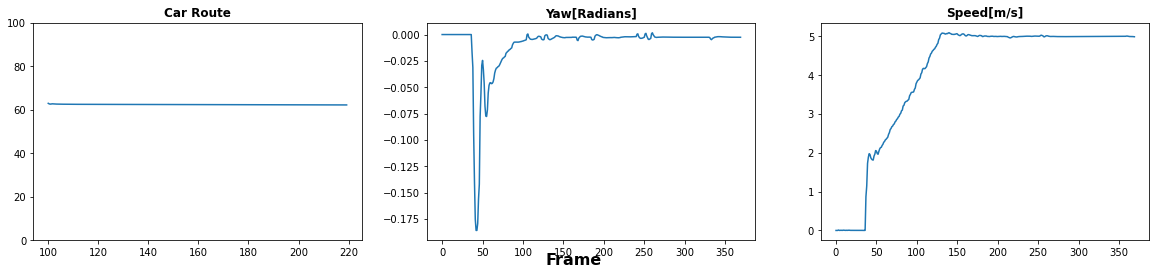

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))
#axes[0].plot(veh_info[:, 0]); axes[0].set_title("X", fontsize=12, fontweight="bold")
#axes[1].plot(veh_info[:, 1]); axes[1].set_title("Y", fontsize=12, fontweight="bold")
axes[0].plot(veh_info[:, 0], veh_info[:, 1]); axes[0].set_title("Car Route", fontsize=12, fontweight="bold")
axes[0].set_ylim([0, 100])
axes[1].plot(veh_info[:, 2]); axes[1].set_title("Yaw[Radians]", fontsize=12, fontweight="bold")
axes[2].plot(veh_info[:, 3]); axes[2].set_title("Speed[m/s]", fontsize=12, fontweight="bold")
fig.text(0.5, 0.04, 'Frame', ha='center', fontsize=16, fontweight="bold")

Text(0.5, 0.0, 'Frame')

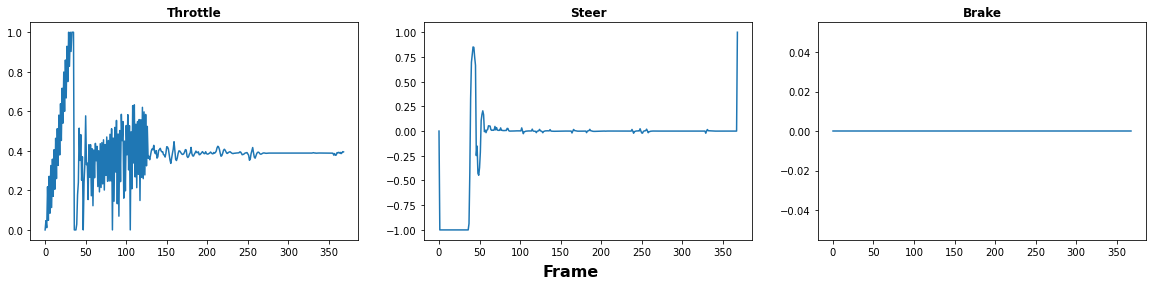

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20,4))
axes[0].plot(control_samples[:, 0]); axes[0].set_title("Throttle", fontsize=12, fontweight="bold")
axes[1].plot(control_samples[:, 1]); axes[1].set_title("Steer", fontsize=12, fontweight="bold")
axes[2].plot(control_samples[:, 2]); axes[2].set_title("Brake", fontsize=12, fontweight="bold")
fig.text(0.5, 0., 'Frame', ha='center', fontsize=16, fontweight="bold")

In [23]:
action = np.hstack((control_samples[:, 1][:, np.newaxis], control_samples[:, 0][:, np.newaxis]))

In [24]:
state_dim = 128
action_space = 2
batch_size = 64
epochs = 10000
n_channel = 3
h_image_in = 80
w_image_in = 160
type_AC = "VAE"
z_dim = 128
beta = 1.0
weights_path= "./weights/segmodel_expert_samples_sem_369.pt"
is_freeze_params = True
linear_layers = []
max_memory_size = 1000000
rw_weights = None,
device = "cuda:0"

trainer = BC(states=images[50:], 
             actions=action[50:, :],
             state_dim=state_dim,
             action_space=action_space,
             batch_size=batch_size,
             epochs=epochs,
             n_channel=n_channel,
             h_image_in=h_image_in,
             w_image_in=w_image_in,
             type_AC=type_AC,
             z_dim=z_dim,
             beta=beta,
             weights_path=weights_path,
             freeze_params=is_freeze_params,
             linear_layers=linear_layers,
             max_memory_size=max_memory_size,
             rw_weights=rw_weights,
             device=device)

In [25]:
loss = trainer.update(get_loss=True)

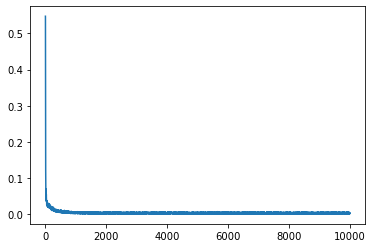

In [26]:
plt.plot(loss)

In [27]:
trainer.load_state_dict("./weights/VAEBC.pt")

In [29]:
actions_pred = None
for i, image in enumerate(images[50:]):
    action = trainer.predict(image, extract_feat=True)
    if i == 0:
        actions_pred = action
    else:
        actions_pred = np.vstack((actions_pred, action))

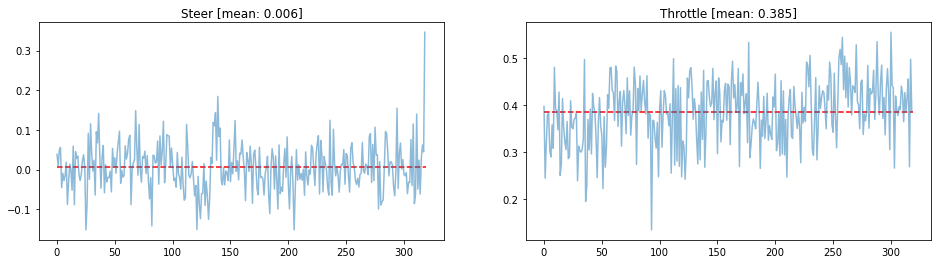

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4)) 
axes[0].plot(actions_pred[:, 0], alpha=.5)
axes[1].plot(actions_pred[:, 1], alpha=.5)

mean_steer = np.mean(actions_pred[:, 0])
mean_throttle = np.mean(actions_pred[:, 1])

axes[0].set_title(f"Steer [mean: {mean_steer:.3f}]")
axes[1].set_title(f"Throttle [mean: {mean_throttle:.3f}]")

axes[0].hlines(mean_steer, 0, actions_pred[:, 0].shape[0], linestyles="dashed", colors='red', alpha=1.)
axes[1].hlines(mean_throttle, 0, actions_pred[:, 1].shape[0], linestyles="dashed", colors='red', alpha=1.)